In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import btrdb
from btrdb.utils.timez import ns_delta, ns_to_datetime, to_nanoseconds

import yaml

### Getting set up

In [2]:
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
#Establishing the connecting to the server
db = btrdb.connect(config['connection']['api_url'], apikey=config['connection']['api_key'])


Here, we'll use the `sunshine` collection discussed in [this blog post](https://blog.ni4ai.org/post/2020-03-30-sunshine-data/). PMU3 is sited at the head of a feeder with a large solar PV array. PMU1 measures power injections by the array itself.

In [163]:
#Choosing streams; we are choosing PMU3 here.
streams = db.streams_in_collection('sunshine/PMU3', tags={'unit': 'volts'})
base_kv = 7.2e3

# Modeling Objective

The figure below shows time series data for a tap change event. [Tap changers]() actuate to adjust the turns ratio on a transfomer to keep the voltage within contractual limits agreed on with the customer. Deeders with distributed energy resources may experience more variability in voltage than legacy power systems. This leads tap changers to actuate much more frequently than they previous would, which can reduce their operating lifespan.

This analysis explores how to use btrdb's `StatPoint` objects to detect when tap changes may have ocurred.

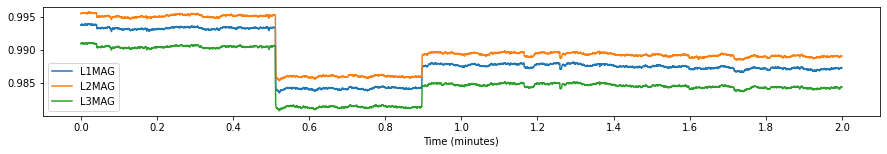

In [199]:
ti = datetime(2015,11,15,4,5)
tf = datetime(2015,11,15,4,7)

data = []
for s in streams:
    vals = s.values(start=ti, end=tf)
    data.append([p.value/base_kv for p, _ in vals])
data = pd.DataFrame(np.array(data).T, columns=[s.name for s in pmu3])

fig, ax = plt.subplots(figsize=(15,2))
data.plot(ax=ax)
ax.set_xticks(np.linspace(0, len(data), 11))
ax.set_xticklabels(np.linspace(0, (tf-ti).total_seconds()/60., 11).round(2))
ax.set_xlabel('Time (minutes)')
plt.show()

# Exploratory Data Analysis

In [4]:
stream = streams[0]
start, _ = stream.earliest()
end, _ = stream.latest()

In [5]:
pw = 44 # or 2^38 nanoseconds

t0 = datetime.now()
points = streams[0].aligned_windows(start=start.time, end=end.time, pointwidth=pw)
dt = points[1][0].time - points[0][0].time


In [6]:
#######################
# The aligned_windows query above returns "statpoints". We'll turn those statistical aggregates into a dataframe.

df = pd.DataFrame(columns=['time','min','max', 'mean','std'], index=range(len(points)))
for i, (p, _) in enumerate(points):
    df.loc[i] = [p.time, p.min/base_kv, p.max/base_kv, p.mean/base_kv, p.stddev/base_kv]
    

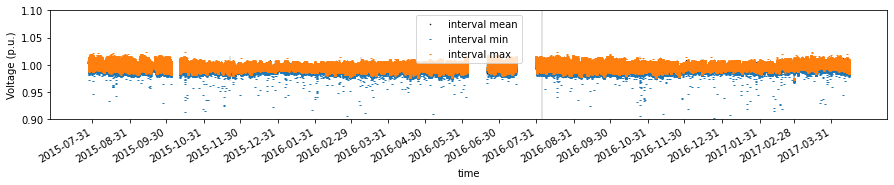

In [160]:
fig, ax = plt.subplots(figsize=(15,2))
ax.vlines(df['time'], df['mean']-df['std'], df['mean']+df['std'], alpha=0.5, color='0.7')
df.plot(x='time', y='mean', label='interval mean', ax=ax, ls=' ', marker='.', color='k', ms=1)
df.plot(x='time', y='min', label='interval min', ax=ax, ls=' ', marker='_', ms=2)
df.plot(x='time', y='max', label='interval max', ax=ax, ls=' ', marker='_', ms=2)
ax.set_ylim(0.9,1.1)
ax.set_ylabel('Voltage (p.u.)')

start_dt = ns_to_datetime(df['time'].min())
end_dt = ns_to_datetime(df['time'].max())
ticks = pd.date_range(start=datetime(start_dt.year,start_dt.month,1), 
                      end=datetime(end_dt.year,end_dt.month,1), freq='m')
ax.set_xticks([to_nanoseconds(t) for t in ticks])
ax.set_xticklabels([t.strftime('%Y-%m-%d') for t in ticks], rotation=30, ha='right')
plt.show()

# Looking for changes in voltage

Taking the difference between `point.min` and `point.max` can tell us how much the voltage changed during each time window. Note that these changes are over the entire interval (in this case ~5 hours), they won't necessarily indicate an instantaneous jump. In other words, the change in voltage is given by:

$$\Delta V = \sup_{i,j \in T} |V_i - V_j|$$

The histogram below shows the distribution of these *changes* in voltage over each time interval.

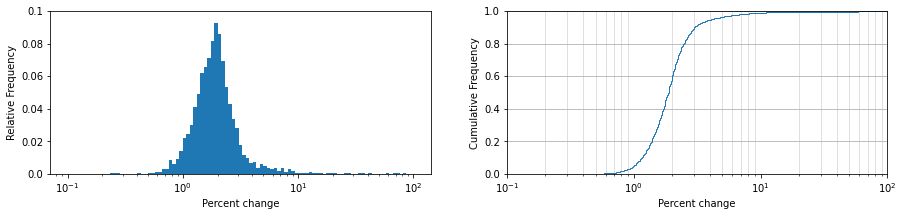

In [9]:
fig, ax = plt.subplots(figsize=(15,3), ncols=2)

change = (df['max']-df['min'])/df['mean']

ax[0].hist(100*change, bins=np.logspace(-1,2, 100))
ax[0].set_ylim(0,len(df)/10.)
ax[0].set_yticks(np.linspace(0,len(df)/10.,6))
ax[0].set_yticklabels(np.round(np.linspace(0,0.1,6),2))
ax[0].set_xlabel('Percent change')
ax[0].set_ylabel('Relative Frequency')
ax[0].set_xscale('log')

ax[1].hist(100*change, bins=np.logspace(-1,2, 500), cumulative=True, histtype='step')
ax[1].set_xlim(1e-1,1e2)
ax[1].set_ylim(0,len(df))
ax[1].set_yticks(np.linspace(0,len(df),6))
ax[1].set_yticklabels(np.round(np.linspace(0,1,6),1))
ax[1].set_xlabel('Percent change')
ax[1].set_ylabel('Cumulative Frequency')
ax[1].set_xscale('log')
plt.grid(which='major', axis='y')
plt.grid(which='minor', axis='x', alpha=0.5)
plt.show()

## Observations

The median voltage change in an interval is only about a 1-2% change w.r.t. the average. The 90th percentile is about a 3% change. It's also worth noting that the distribution has a long right tail; these values likely correspond to faults.

# Drilling in to smaller StatPoints

Summary statistics computed over long time windows can mask near-term variability. Over the span of several hours, the voltage may change quite a bit. A tap changer could actuate multiple times, or voltage sags and spikes could occur due to other types of events. In order to differentiate different types of events, or to detect individual tap changes, we need to consider a smaller time window that's better aligned with the time scale on which a tap changer actuates.

Here, we'll drill down from a 5-hour to a 5-minute time window.

In [10]:
pw = 38 # 4.58 minutes (2^38 nanoseconds)

t0 = datetime.now()
points = streams[0].aligned_windows(start=start.time, end=end.time, pointwidth=pw)
dt = points[1][0].time - points[0][0].time

print('pointwidth:\t%.2f minutes'%(dt/1e9/60))
print('statpoints:\t%i points'%(len(points)))

pointwidth:	4.58 minutes
statpoints:	184549 points


In [11]:
df = pd.DataFrame(columns=['time','min','max','mean','std', 'count'], index=range(len(points)))
for i, (p, _) in enumerate(points):
    df.loc[i] = [p.time, p.min/base_kv, p.max/base_kv, p.mean/base_kv, p.stddev/base_kv, p.count]

In [12]:
df.head()

,time,min,max,mean,std,count
0,1438041362363580416,1.00366,1.00648,1.00521,0.00046367,4468
1,1438041637241487360,1.00344,1.00718,1.00557,0.000505696,32986
2,1438041912119394304,1.00388,1.00901,1.00719,0.000803995,47385
3,1438042186997301248,1.00611,1.00929,1.00828,0.000598412,32986
4,1438042461875208192,1.00686,1.01252,1.01013,0.00092642,32985


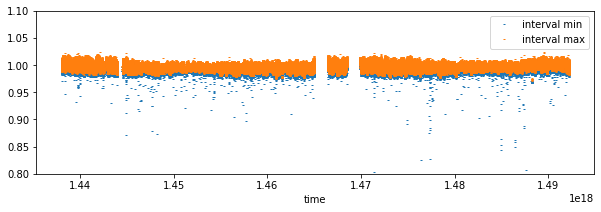

In [13]:
fig, ax = plt.subplots(figsize=(10,3))
df.plot(x='time', y='min', label='interval min', ax=ax, ls=' ', marker='_', ms=2)
df.plot(x='time', y='max', label='interval max', ax=ax, ls=' ', marker='_', ms=2)
ax.set_ylim(0.8,1.1)
plt.show()

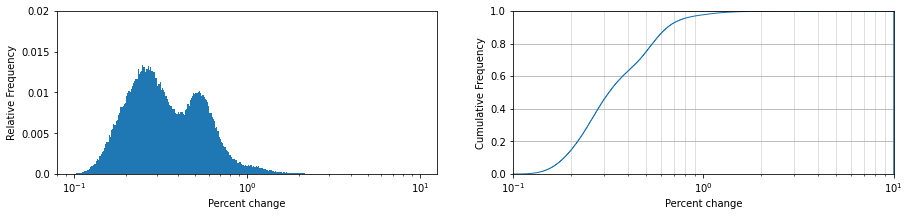

In [162]:
def rescale_y(ax=None, count=1, ymax=None, nticks=5):
    ax.set_ylim(0, ymax*count)
    ax.set_yticks(np.linspace(0, ymax*count, nticks))
    ax.set_yticklabels(np.round(np.linspace(0, ymax, nticks), 3))

fig, ax = plt.subplots(figsize=(15,3), ncols=2)

change = (df['max']-df['min'])/df['mean']

ax[0].hist(100*change, bins=np.logspace(-1,1, 300))
ax[0].set_xlabel('Percent change')
ax[0].set_ylabel('Relative Frequency')
ax[0].set_xscale('log')
rescale_y(ax=ax[0], count=len(df), ymax=0.02, nticks=5)

ax[1].hist(100*change, bins=np.logspace(-1,1, 1000), cumulative=True, histtype='step')
ax[1].set_xlim(1e-1,1e1)
ax[1].set_xlabel('Percent change')
ax[1].set_ylabel('Cumulative Frequency')
ax[1].set_xscale('log')
rescale_y(ax=ax[1], count=len(df), ymax=1, nticks=6)

plt.grid(which='major', axis='y')
plt.grid(which='minor', axis='x', alpha=0.5)
plt.show()

## Observations
First, note that the x-axis is on a logarithmic scale.

The distribution is clearly multimodal. The saddle point between the two distributions looks to be at about 0.4% change (on the x axis). This means that in about 60% of the time intervals measured, the voltage changes by less than about 0.4%. Among the remaining 30% of time intervals, the voltage changes between about 0.4% and 0.8%. We also see the hint of a third distribution in the upper tail -- suggesting that in some much smaller subset of intervals, we see the voltage change by closer to 1% or more.

## Follow up question: 
Are there meaningful patterns in the data that could help us determine whether the voltage change within a statpoint interval is due to random variability (e.g., in load or solar generation), or due to discrete events -- such as tap changer operations or faults.

In [15]:
times = pd.DatetimeIndex(df['time'].apply(ns_to_datetime))

In [16]:
bins = np.logspace(-1,1, 100)
hvals = np.histogram(100*change, bins=bins)

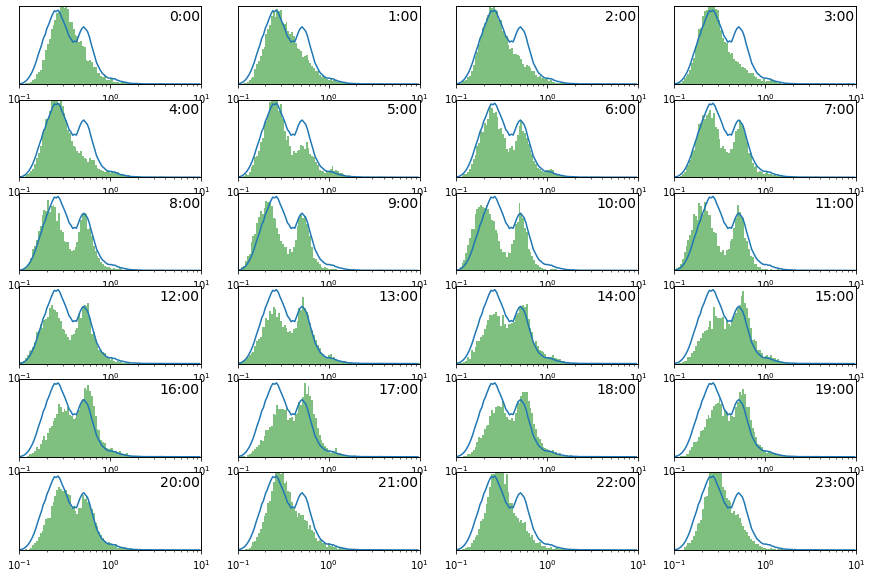

In [17]:
bins = np.logspace(-1,1, 100)
fig, ax = plt.subplots(figsize=(15,10), ncols=4, nrows=6)
for hr, _ax in zip(range(24), ax.flatten()):
    axt = _ax.twinx()
    axt.plot(bins[:-1], hvals[0])
    axt.set_yticks([])
    axt.set_xlim(min(bins), max(bins))
    axt.set_ylim(0, axt.get_ylim()[1])
    
    _ax.hist(100*change[times.hour == hr], 
             bins=bins, alpha=0.5, color='g',
            label='t=%i:00'%(hr))
    _ax.set_xscale('log')
    _ax.set_xlim(min(bins), max(bins))
    _ax.set_ylim(0,0.05*axt.get_ylim()[1])
    _ax.set_yticks([])
    _ax.text(0.96*max(bins), 0.96*_ax.get_ylim()[1], '%i:00'%(hr), fontsize=14, ha='right', va='top')
plt.show()

## Observations

The distribution clearly tends to be more uni-modal at night, and more bi-modal during the day.

## Follow up question
Is the change in voltage conditionally dependent on PV power production?

In [18]:
c_streams = [s for s in db.streams_in_collection('sunshine') 
             if s.name == 'C1MAG' and s.collection.split('/')[-1] in ['PMU1','PMU3']]

pmu3 = c_streams[0].aligned_windows(start=start.time, end=end.time, pointwidth=38)
pmu1 = c_streams[1].aligned_windows(start=start.time, end=end.time, pointwidth=38)

In [19]:
c1 = pd.DataFrame([(p.time, p.mean) for p,_ in pmu1], columns=['time','pmu1'])
c3 = pd.DataFrame([(p.time, p.mean) for p,_ in pmu3], columns=['time','pmu3'])

current = c1.merge(c3, on='time', how='outer')
current.head()

,time,pmu1,pmu3
0,1443715666996625408,0.146385,36.521501
1,1443715941874532352,0.150786,40.429870
2,1443716216752439296,0.153961,41.788657
3,1443716491630346240,0.158563,43.717787
4,1443716766508253184,0.165838,48.718669


In [21]:
df['change'] = (df['max']-df['min'])/df['mean']
df.head()

,time,min,max,mean,std,count,change
0,1438041362363580416,1.00366,1.00648,1.00521,0.00046367,4468,0.00280461
1,1438041637241487360,1.00344,1.00718,1.00557,0.000505696,32986,0.00371987
2,1438041912119394304,1.00388,1.00901,1.00719,0.000803995,47385,0.00509703
3,1438042186997301248,1.00611,1.00929,1.00828,0.000598412,32986,0.00315296
4,1438042461875208192,1.00686,1.01252,1.01013,0.00092642,32985,0.00560687


In [27]:
current = current.set_index('time')
data = df.copy().set_index('time')
data['I1'] = current['pmu1'].loc[data.index]
data['I3'] = current['pmu3'].loc[data.index]

In [ ]:
# data = df.merge(current, how='left', on='time')
# data.head()

# Current Flow

### How does the current at PMU1 (pv array) relate to the current at PMU3 (substation)?

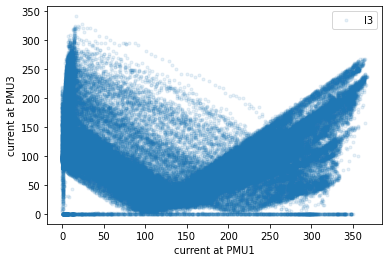

In [58]:
from scipy import stats
import matplotlib as mpl

fig, ax = plt.subplots()
data.plot(ax=ax, x='I1', y='I3', ls=' ', marker='.', alpha=0.1)
ax.set_xlabel('current at PMU1')
ax.set_ylabel('current at PMU3')
plt.show()


## Observations

## Follow up question: *What is the density of points in different areas of the plot?*

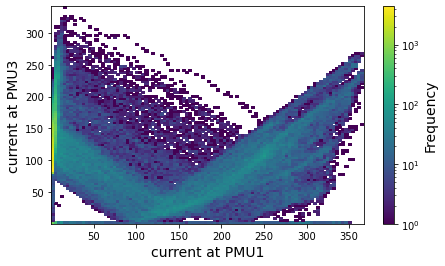

In [67]:

fig, ax = plt.subplots(figsize=(7,4))
idx = pd.isnull(data).sum(axis=1)==0
h = ax.hist2d(data['I1'][idx], data['I3'][idx], bins=100, norm=mpl.colors.LogNorm())#, color=mpl.cm.gray)
cbar = fig.colorbar(h[3], ax=ax)
cbar.set_label('Frequency', fontsize=14)
# data.hist2d(ax=ax, x='I1', y='I3', ls=' ', marker='.', alpha=0.1)
ax.set_xlabel('current at PMU1', fontsize=14)
ax.set_ylabel('current at PMU3', fontsize=14)
plt.show()


### Histogram of current measurements at each site

Text(0.5, 1.0, 'PMU 3')

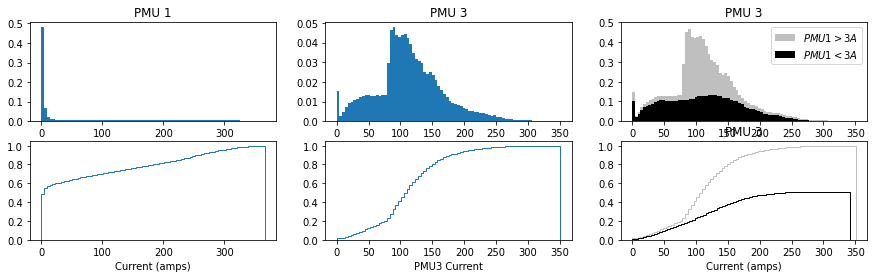

In [159]:
fig, ax = plt.subplots(figsize=(15,4), ncols=3, nrows=2)

bins = 80 

_ax = ax[0,0]
h = _ax.hist(data['I1'], bins=bins)
_ax.set_xlabel('Current (amps)')
_ax.set_yticks(np.linspace(0, 0.5*sum(h[0]), 6))
_ax.set_yticklabels(np.linspace(0, 0.5, 6).round(1))
_ax.set_title('PMU 1')
_ax.set_ylabel('Density')


_ax = ax[1,0]
h = _ax.hist(data['I1'], bins=bins, cumulative=True, histtype='step')
_ax.set_xlabel('Current (amps)')
_ax.set_yticks(np.linspace(0, max(h[0]), 6))
_ax.set_yticklabels(np.linspace(0, 1, 6).round(1))
_ax.set_ylabel('Cumulative Density')

_ax = ax[0,1]
h = _ax.hist(data['I3'], bins=bins)
_ax.set_xlabel('Current (amps)')
_ax.set_yticks(np.linspace(0, 0.05*sum(h[0]), 6))
_ax.set_yticklabels(np.linspace(0, 0.05, 6).round(2))
_ax.set_title('PMU 3')
_ax.set_ylabel('Density')


_ax = ax[1,1]
h = _ax.hist(data['I3'], bins=bins, cumulative=True, histtype='step')
_ax.set_xlabel('PMU3 Current')
_ax.set_yticks(np.linspace(0, max(h[0]), 6))
_ax.set_yticklabels(np.linspace(0, 1, 6).round(1))
_ax.set_ylabel('Cumulative Density')


idx = data['I1'] > 3

_ax = ax[0,2]
h = _ax.hist(data['I3'], bins=bins, color='0.5', alpha=0.5, label=r'$PMU1>3A$')
h = _ax.hist(data['I3'][idx], bins=bins, color='k', label=r'$PMU1<3A$')
_ax.set_xlabel('Current (amps)')
_ax.set_yticks(np.linspace(0, 0.1*sum(h[0]), 6))
_ax.set_yticklabels(np.linspace(0, 0.5, 6).round(1))
_ax.legend()
_ax.set_title('PMU 3')
_ax.set_ylabel('Density')


_ax = ax[1,2]
h = _ax.hist(data['I3'], bins=bins, color='0.5', alpha=0.5, cumulative=True, histtype='step')

_ax.set_yticks(np.linspace(0, max(h[0]), 6))
_ax.set_yticklabels(np.linspace(0, 1, 6).round(1))

h = _ax.hist(data['I3'][idx], bins=bins, color='k', cumulative=True, histtype='step')
_ax.set_xlabel('Current (amps)')
_ax.set_title('PMU 3')
_ax.set_ylabel('Cumulative Density')

plt.show()

In [168]:
pmu1 = [s for s in db.streams_in_collection('sunshine') if 'PMU1' in s.collection and s.tags()['unit'] == 'volts']
pmu3 = [s for s in db.streams_in_collection('sunshine') if 'PMU3' in s.collection and s.tags()['unit'] == 'volts']

In [169]:
pmu1

[<Stream collection=sunshine/PMU1 name=L3MAG>,
 <Stream collection=sunshine/PMU1 name=L1MAG>,
 <Stream collection=sunshine/PMU1 name=L2MAG>]

## Observations



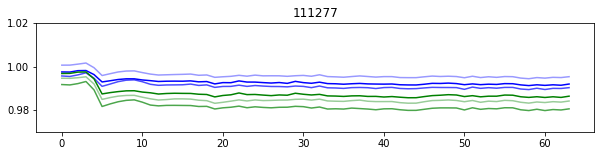

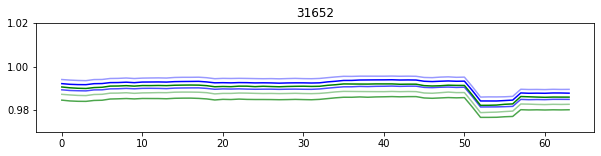

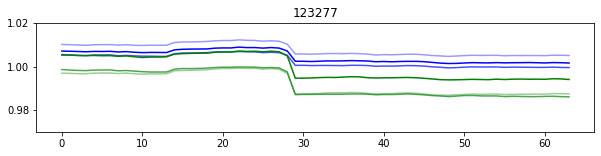

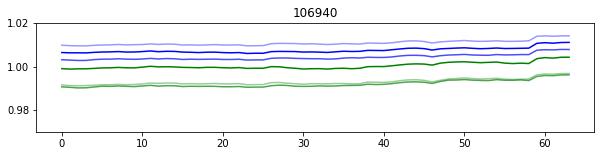

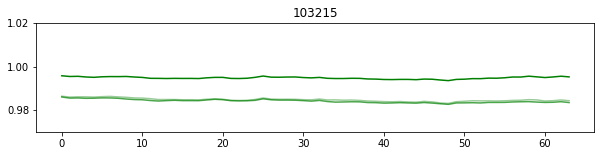

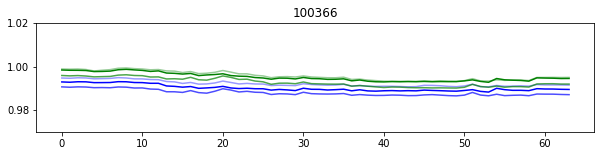

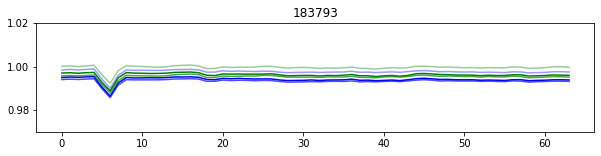

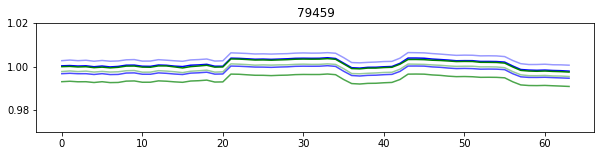

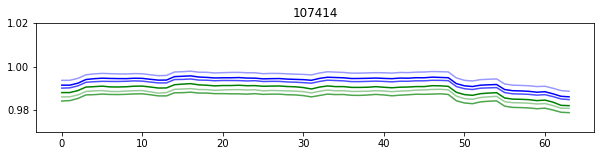

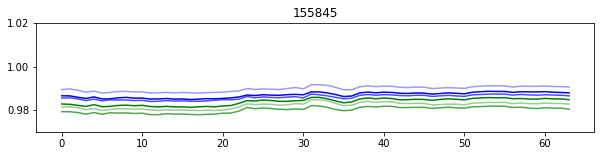

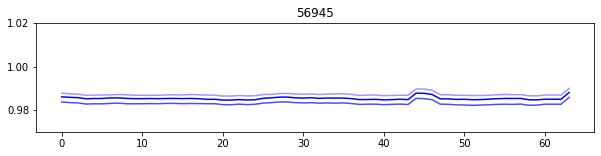

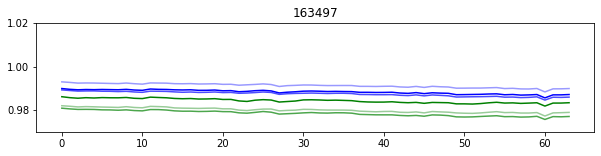

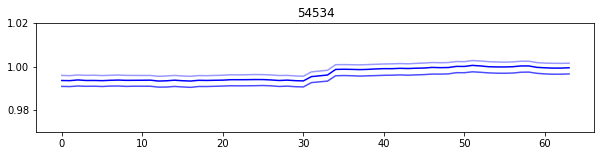

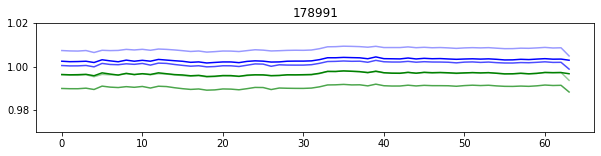

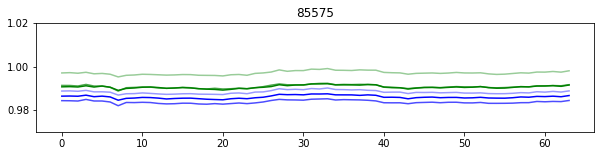

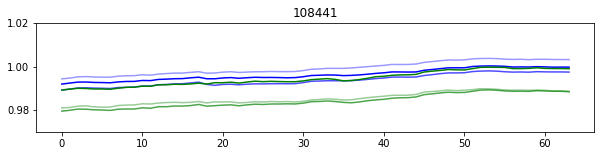

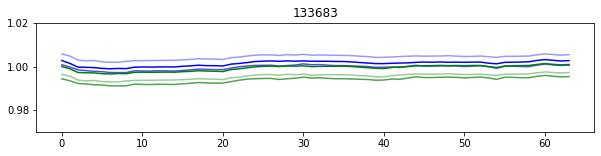

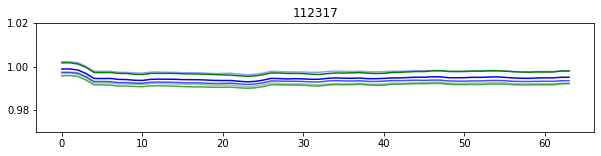

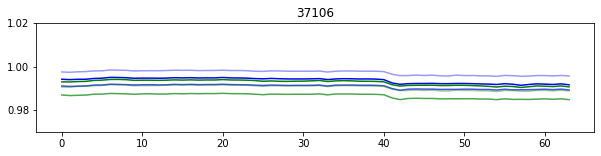

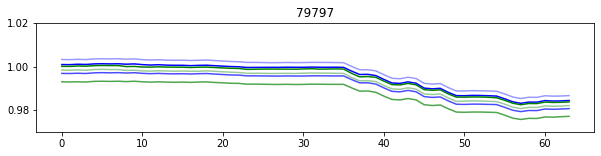

In [583]:
idx = change > np.percentile(change,90)

for interval in np.random.choice(change[idx].index, size=20):
    start = df['time'].loc[interval]
    end = df['time'].loc[interval + 1]
    fig, ax = plt.subplots(figsize=(10,2))
    alphas = {'L1MAG': 1,'L2MAG': 0.4,'L3MAG': 0.7}
    for s in pmu3:
        window = s.aligned_windows(start=start, end=end, pointwidth=32)
        ax.plot([w.mean/base_kv for w, _ in window], color='b', alpha=alphas[s.name])
    
    for s in pmu1:
        window = s.aligned_windows(start=start, end=end, pointwidth=32)
        ax.plot([w.mean/base_kv for w, _ in window], color='g', alpha=alphas[s.name])
    
    plt.title(interval)
    plt.ylim(0.97, 1.02)
    plt.show()

In [181]:
interval = 31652

start = df['time'].loc[interval]
end = df['time'].loc[interval + 1]
mid = start + 0.5*(end-start)

data = []
for s in pmu3:
    vals = s.values(start=mid, end=end)
    data.append([p.value for p, _ in vals])


In [183]:
ns_to_datetime(end)

datetime.datetime(2015, 11, 15, 4, 6, 24, 281051, tzinfo=<UTC>)

In [196]:
np.arange(0,121,15)

array([  0,  15,  30,  45,  60,  75,  90, 105, 120])

<AxesSubplot:>

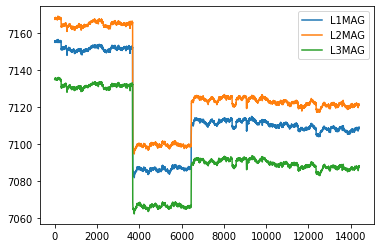

In [187]:
pd.DataFrame(np.array(data).T, columns=[s.name for s in pmu3]).plot()

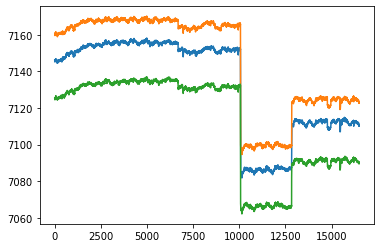

In [172]:
fig, ax = plt.subplots()
ax.plot(data[0])
ax.plot(data[1])
ax.plot(data[2])
plt.show()

In [599]:
pts, _ = zip(*vals)

In [601]:
pts[0].value

7125.6015625

In [590]:
from btrdb.utils.timez import ns_to_datetime

ns_to_datetime(start), ns_to_datetime(start + 0.5*(end-start)), ns_to_datetime(end)

(datetime.datetime(2015, 11, 15, 4, 1, 49, 403144, tzinfo=<UTC>),
 datetime.datetime(2015, 11, 15, 4, 4, 6, 842098, tzinfo=<UTC>),
 datetime.datetime(2015, 11, 15, 4, 6, 24, 281051, tzinfo=<UTC>))

In [549]:
probs = gmm.predict_proba(np.logspace(-1,1,300).reshape(300,1))
print(probs[:,0].sum(), probs[:,1].sum())
print(gmm.weights_)
probs.shape

300.0 4.904645966313345e-59
[0.46604821 0.53395179]


(300, 2)

# Changes in sampling distribution

Change points are indicative of outliers, or of a shift in the sampling distribution. If we assume that the sampling distribution is stationary w.r.t. time, we can compute the likelihood of observing the min and max values recorded, given some sampling distribution. Since the min and max within a particular window may skew these summary statistics, we'll look at the sampling distribution from the previous window.

In [351]:
likelihoods = pd.DataFrame(columns=['min','max'], index=df.index[1:])
for i, row in df.iterrows():
    if i == 0:
        continue
    rv = stats.norm(loc=df['mean'].loc[i-1], scale=df['std'].loc[i-1])
    likelihoods.loc[i] = rv.pdf([row['min'], row['max']])


Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


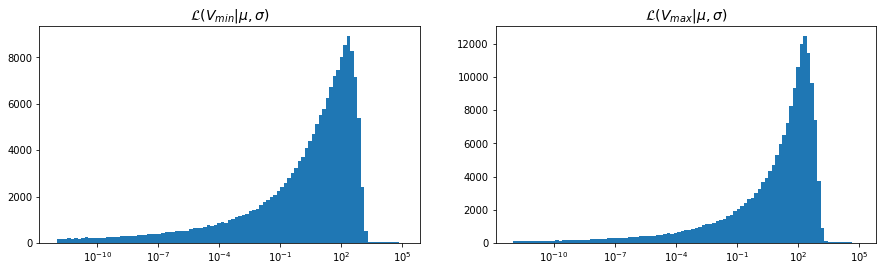

In [362]:
fig, ax = plt.subplots(ncols=2, figsize=(15,4))
ax[0].hist(likelihoods['min'], bins=np.logspace(-12,5,100))
ax[1].hist(likelihoods['max'], bins=np.logspace(-12,5,100))

ax[0].set_title(r'$\mathcal{L}(V_{min}|\mu, \sigma)$', fontsize=14)
ax[1].set_title(r'$\mathcal{L}(V_{max}|\mu, \sigma)$', fontsize=14)

ax[0].set_xscale('log')
ax[1].set_xscale('log')

plt.show()

In [385]:
def t_test(p1, p2):
    # calculate the pooled variance across the two samples
    s_p = np.sqrt(0.5*(p1['std']**2+p2['std']**2))
    return (p2['mean']-p1['mean'])/(s_p*np.sqrt(2/p2['count']))


tstats = pd.DataFrame(columns=['lag1', 'lag2'], index=df.index[2:])
pvalue = pd.DataFrame(columns=['lag1', 'lag2'], index=df.index[2:])

for i in tstats.index:
    sp0 = df.loc[i].loc[['mean','std','count']].tolist()
    sp1 = df.loc[i-1].loc[['mean','std','count']].tolist()
    sp2 = df.loc[i-2].loc[['mean','std','count']].tolist()
    
    tstat, pval = stats.ttest_ind_from_stats(*list(sp0+sp1))
    tstats['lag1'].loc[i] = tstat
    pvalue['lag1'].loc[i] = pval
    
    tstat, pval = stats.ttest_ind_from_stats(*list(sp0+sp2))
    tstats['lag2'].loc[i] = tstat
    pvalue['lag2'].loc[i] = pval
    


In [389]:
pvalue

,lag1,lag2
2,0,0
3,0,0
4,0,0
5,1.95689e-19,0
6,6.05612e-255,3.8145e-104
...,...,...
184544,NaN,NaN
184545,NaN,NaN
184546,NaN,NaN
184547,NaN,NaN


0.05 0.00269849956921543 498
0.05 0.002655150178545303 490
0.025 0.00269849956921543 498
0.025 0.002649731504711537 489
0.01 0.0026930808953816643 497
0.01 0.002644312830877771 488
0.001 0.0026876622215478985 496
0.001 0.002644312830877771 488


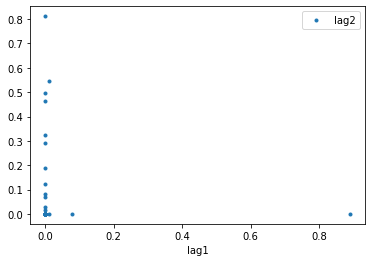

In [401]:
pvalue.plot(x='lag1', y='lag2', ls=' ', marker='.')

alphas = [0.05,0.025,0.01,0.001]
for a in alphas:
    idx = pvalue['lag1'] <= a
    print(a, sum(idx)/len(idx), sum(idx))
    
    
    idx = pvalue['lag2'] <= a
    print(a, sum(idx)/len(idx), sum(idx))


In [ ]:
intervals = pvalue.loc[pvalue['lag1']<=0.01].index

for i in intervals:
    st = df['time'].loc[i]
    end = df['time'].loc[i+1]
    
    points = db.

In [ ]:
idx = likelihoods['diff'] < 0.01

0.60    0.376919
0.95    0.776518
dtype: object


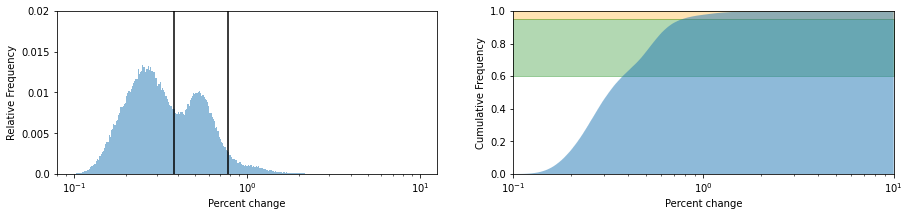

In [282]:

fig, ax = plt.subplots(figsize=(15,3), ncols=2)

change = (df['max']-df['min'])/df['mean']
quantiles = (100*change).quantile([0.6,0.95])
print(quantiles)

ax[0].hist(100*change, bins=np.logspace(-1,1, 300), alpha=0.5)
ymax = 0.02
ax[0].set_ylim(0,ymax*len(df))
ax[0].set_yticks(np.linspace(0,ymax*len(df),5))
ax[0].set_yticklabels(np.round(np.linspace(0,ymax,5),3))
ax[0].set_xlabel('Percent change')
ax[0].set_ylabel('Relative Frequency')
ax[0].set_xscale('log')
ax[0].vlines(quantiles, *ax[0].get_ylim(), color='k')

ax[1].hist(100*change, bins=np.logspace(-1,1, 1000), cumulative=True, histtype='stepfilled', alpha=0.5)
ax[1].set_xlim(1e-1,1e1)
ax[1].set_ylim(0,len(df))
ax[1].set_yticks(np.linspace(0,len(df),6))
ax[1].set_yticklabels(np.round(np.linspace(0,1,6),1))
ax[1].set_xlabel('Percent change')
ax[1].set_ylabel('Cumulative Frequency')
ax[1].set_xscale('log')
ax[1].fill_betweenx([len(df)*quantiles.index[1],len(df)], *ax[1].get_ylim(), color='orange', alpha=0.3)
ax[1].fill_betweenx(len(df)*quantiles.index, *ax[1].get_xlim(), color='g', alpha=0.3)

plt.show()

# Anomaly detection

StatPoints report the mean and variance among samples in each interval, as well as the min and max values. If we assume that samples within a window are normally distributed, we can use StatPoint values to estimate the *likelihood* that the min and/or max values are drawn from the same sampling distribution as other points in the interval.

In [303]:
from scipy import stats

def t_test(point1, point2):
    return (point2['mean']-point1['mean'])/(point1['std']/np.sqrt(point2['count']))

scores = pd.Series(index=df.index)
for ix1, ix2 in zip(df.index[:-1], df.index[1:]):
    scores.loc[ix2] = t_test(df.loc[ix1], df.loc[ix2])

/Users/laureldunn/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


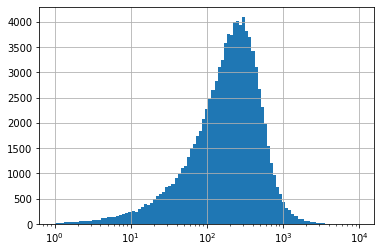

In [308]:
scores.hist(bins=np.logspace(0,4,100))
plt.xscale('log')
plt.show()

,time,min,max,mean,std,count
0,1438041362363580416,1.00366,1.00648,1.00521,0.00046367,4468
1,1438041637241487360,1.00344,1.00718,1.00557,0.000505696,32986
2,1438041912119394304,1.00388,1.00901,1.00719,0.000803995,47385
3,1438042186997301248,1.00611,1.00929,1.00828,0.000598412,32986
4,1438042461875208192,1.00686,1.01252,1.01013,0.00092642,32985


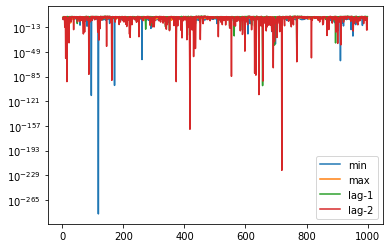

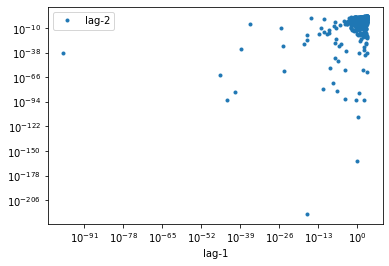

In [301]:
likelihoods.plot()
plt.yscale('log')

likelihoods.plot(x='lag-1', y='lag-2', ls=' ', marker='.')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [253]:
events = []
for low, high in zip(quantiles[:-1], quantiles[1:]):
    idx = (change > low) & (change <  high)
    intervals = np.random.choice(df[idx].index, size=100)
    ts = pd.DataFrame(columns=range(len(intervals)))

    for i, jx in enumerate(intervals):
        _start = df['time'].loc[jx]
        if jx+1 <= len(df):
            _end = df['time'].loc[jx+1]
        else:
            _end = _start + 2**38 - 1
        try:
            points = streams[0].aligned_windows(start=_start, end=_end, pointwidth=pw)
        except:
            print('error')
        ts[i] = [p.mean/base_kv for p, v in points]
    
    events.append(df)


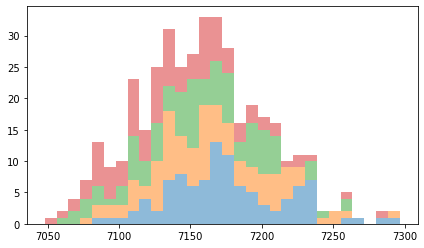

In [258]:
fig, ax = plt.subplots(figsize=(7,4))
vals = []
for i, e in enumerate(events):
    vals.append(e.min())
ax.hist(vals, bins=30, stacked=True, alpha=0.5)
plt.show()

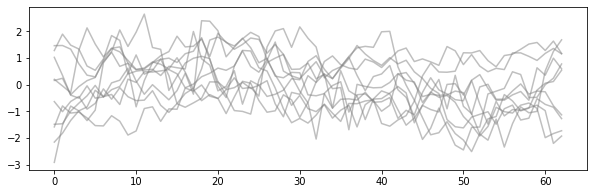

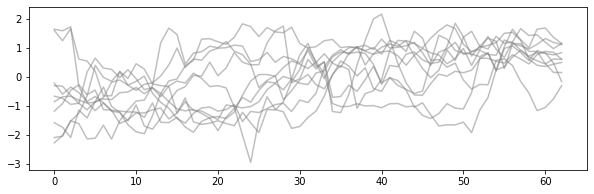

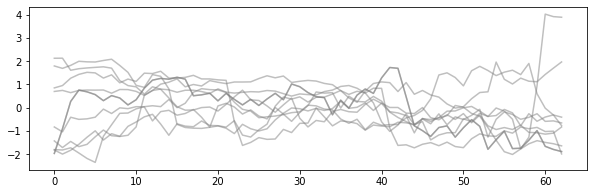

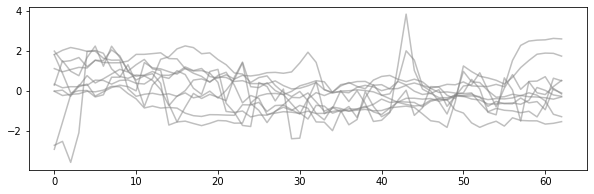

In [261]:
for i, e in enumerate(events):
    fig, ax = plt.subplots(figsize=(10,3))
    for j in np.random.choice(e.keys(), size=10):
        ax.plot(range(len(e)), ((e[j]-e[j].mean())/e[j].std()).tolist(), alpha=0.5, color='0.5')
    plt.show()

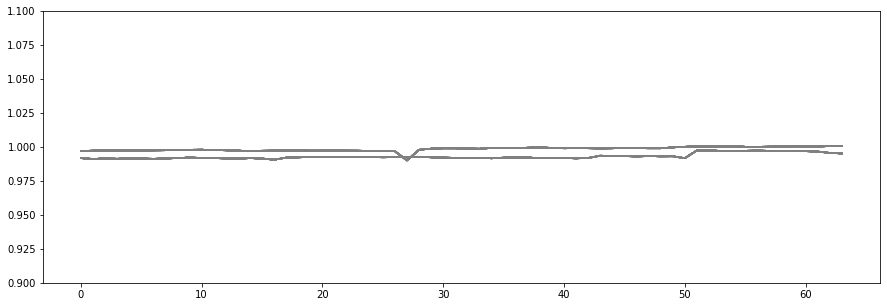

In [185]:
# idx = (change > quantiles[1]) & (change < quantiles[2])
# intervals = np.random.choice(df[idx].index, size=100)
# ts = pd.DataFrame(columns=range(len(intervals)))

# for i, jx in enumerate(intervals):
#     start = df['time'].loc[jx]
#     end = df['time'].loc[jx+1]
#     points = streams[0].aligned_windows(start=start, end=end, pointwidth=pw)
#     ts[i] = [p.mean/base_kv for p, v in points]

fig, ax = plt.subplots(figsize=(15,5))
for i in ts.keys():
    ax.plot(range(len(ts)), ts[i].tolist(), color='0.5', alpha=0.5)
ax.set_ylim(0.9, 1.1)
plt.show()

In [187]:
for low, high in zip(quantiles[:-1], quantiles[1:]):
    idx = 

[0.0061745783586085205,
 0.21854691514562685,
 0.2798167006868907,
 0.37691864096836747,
 0.540610175331443,
 111.87979150992304]

In [186]:
sum(idx)

2

In [148]:
df.head()

,time,min,max,mean,std,count
0,1438041362363580416,1.00366,1.00648,1.00521,0.00046367,4468
1,1438041637241487360,1.00344,1.00718,1.00557,0.000505696,32986
2,1438041912119394304,1.00388,1.00901,1.00719,0.000803995,47385
3,1438042186997301248,1.00611,1.00929,1.00828,0.000598412,32986
4,1438042461875208192,1.00686,1.01252,1.01013,0.00092642,32985


In [170]:
np.linspace(0.01,0.99,6)

array([0.01 , 0.206, 0.402, 0.598, 0.794, 0.99 ])